In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
combined_data = pd.read_csv('datasets/feature_engineered_aqi_data_local.csv')

In [3]:
combined_data.head()

,date,city,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,uv_index_clear_sky,uv_index,dust,aerosol_optical_depth,us_aqi,hour_sin,hour_cos,month_sin,month_cos,day_of_week,year
0,2023-06-01 06:00:00+00:00,dhaka,51.3,34.1,369.0,17.9,8.6,44.0,0.15,0.15,1.0,1.17,152.57675,1.000000,6.123234e-17,1.224647e-16,-1.0,3,2023
1,2023-06-01 07:00:00+00:00,dhaka,50.2,32.5,381.0,19.3,10.4,53.0,0.65,0.50,1.0,1.27,151.45615,0.965926,-2.588190e-01,1.224647e-16,-1.0,3,2023
2,2023-06-01 08:00:00+00:00,dhaka,51.3,32.9,397.0,21.1,12.9,67.0,1.75,1.55,1.0,1.26,150.46272,0.866025,-5.000000e-01,1.224647e-16,-1.0,3,2023
3,2023-06-01 09:00:00+00:00,dhaka,58.4,37.8,410.0,21.4,15.5,92.0,3.25,3.20,1.0,1.27,148.54167,0.707107,-7.071068e-01,1.224647e-16,-1.0,3,2023
4,2023-06-01 10:00:00+00:00,dhaka,71.5,46.9,405.0,18.0,16.0,121.0,4.80,4.65,1.0,1.34,146.14584,0.500000,-8.660254e-01,1.224647e-16,-1.0,3,2023


In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
le = LabelEncoder()
combined_data['city_encoded'] = le.fit_transform(combined_data['city'])

In [6]:
X = combined_data[[col for col in combined_data.columns if col not in ["date", "us_aqi", "city"]]]
y = combined_data["us_aqi"]

In [7]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=43)

## RIDGE REGRESSION

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
ridge = Ridge()
params = {'alpha': [1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20]}
ridge_cv = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=3)
ridge_cv.fit(X,y)

,estimator,Ridge()
,param_grid,"{'alpha': [1e-15, 1e-10, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,20


In [9]:
ridge_cv.best_params_

{'alpha': 20}

In [10]:
ridge_cv.best_score_

np.float64(-576.9980874587051)

## LASSO REGRESSION

In [11]:
from sklearn.linear_model import Lasso
lasso = Lasso(tol=1)
# used tol = 1 since warning was given that convergence not taking place
params = {'alpha': [1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 50]}
lasso_cv = GridSearchCV(lasso, params, scoring='neg_mean_squared_error', cv=3)
lasso_cv.fit(X,y)

,estimator,Lasso(tol=1)
,param_grid,"{'alpha': [1e-15, 1e-10, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1


In [12]:
lasso_cv.best_params_

{'alpha': 1}

In [13]:
lasso_cv.best_score_

np.float64(-520.53427572168)

In [14]:
pred = lasso_cv.predict(X_test)

C:\Users\stasn\AppData\Local\Temp\ipykernel_25688\731847810.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-pred)


<Axes: xlabel='us_aqi', ylabel='Density'>

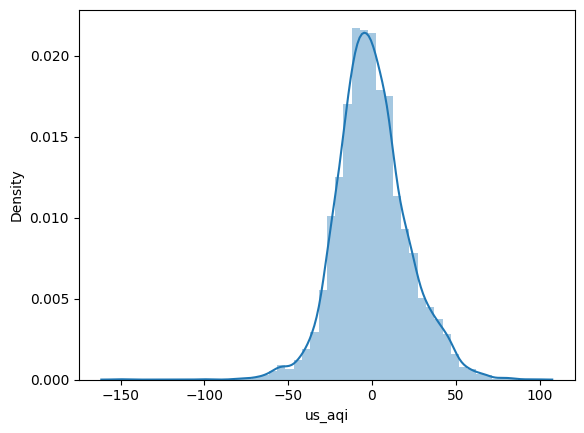

In [15]:
sns.distplot(y_test-pred)

In [16]:
from sklearn import metrics
print(f"Mean Abs Error: {metrics.mean_absolute_error(y_test, pred)}")
print(f"Mean Sq Error: {metrics.mean_squared_error(y_test, pred)}")
print(f"Root Mean Error: {np.sqrt(metrics.mean_squared_error(y_test, pred))}")

Mean Abs Error: 15.991265817363
Mean Sq Error: 435.9937635718984
Root Mean Error: 20.880463681918044


In [17]:
import pickle
pickle.dump(lasso_cv, open('models/lasso.pkl', 'wb'))